In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Twitter Data

### Import and join of json files with tweet data

The json data files for each day's tweets are pulled and appended to one another.

In [1]:
import json

tweet_files = ['#NetNeutrality/#NetNeutrality_2018-01-22.json', 'net/net_2018-01-22.json', '#NetNeutrality/#NetNeutrality_2018-01-23.json', 'net/net_2018-01-23.json', '#NetNeutrality/#NetNeutrality_2018-01-24.json', 'net/net_2018-01-24.json', '#NetNeutrality/#NetNeutrality_2018-01-25.json', 'net/net_2018-01-25.json', '#NetNeutrality/#NetNeutrality_2018-01-26.json', 'net/net_2018-01-26.json', '#NetNeutrality/#NetNeutrality_2018-01-27.json', 'net/net_2018-01-27.json', '#NetNeutrality/#NetNeutrality_2018-01-28.json', 'net/net_2018-01-28.json', '#NetNeutrality/#NetNeutrality_2018-01-29.json', 'net/net_2018-01-29.json', '#NetNeutrality/#NetNeutrality_2018-01-30.json', 'net/net_2018-01-30.json', '#NetNeutrality/#NetNeutrality_2018-01-31.json', 'net/net_2018-01-31.json', '#NetNeutrality/#NetNeutrality_2018-02-01.json', 'net/net_2018-02-01.json', '#NetNeutrality/#NetNeutrality_2018-02-02.json', 'net/net_2018-02-02.json', '#NetNeutrality/#NetNeutrality_2018-02-03.json', 'net/net_2018-02-03.json', '#NetNeutrality/#NetNeutrality_2018-02-04.json', 'net/net_2018-02-04.json', '#NetNeutrality/#NetNeutrality_2018-02-05.json', 'net/net_2018-02-05.json', '#NetNeutrality/#NetNeutrality_2018-02-06.json', 'net/net_2018-02-06.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

### Data Wrangling

A number of steps can be taken to investigate and clean the tweet data prior to analysis.

#### Investigate fields of a tweet

In [2]:
print(tweets[0])

{'created_at': 'Mon Jan 22 23:59:48 +0000 2018', 'id': 955590854734958592, 'id_str': '955590854734958592', 'text': 'RT @MatthewBender9: #NetNeutrality How it’s going to look like https://t.co/sFqFXWVnOz', 'truncated': False, 'entities': {'hashtags': [{'text': 'NetNeutrality', 'indices': [20, 34]}], 'symbols': [], 'user_mentions': [{'screen_name': 'MatthewBender9', 'name': 'Ghillie', 'id': 2425832674, 'id_str': '2425832674', 'indices': [3, 18]}], 'urls': [], 'media': [{'id': 941417228330766337, 'id_str': '941417228330766337', 'indices': [63, 86], 'media_url': 'http://pbs.twimg.com/media/DRCV-zgWkAE7eaB.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DRCV-zgWkAE7eaB.jpg', 'url': 'https://t.co/sFqFXWVnOz', 'display_url': 'pic.twitter.com/sFqFXWVnOz', 'expanded_url': 'https://twitter.com/MatthewBender9/status/941417235545018370/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 1200, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 680, '

#### Definition of features to be created in dataframe from json files

In [3]:
import pandas as pd

def populate_tweet_df(tweets):
    df = pd.DataFrame()
    df['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets))                
    df['tweet_date'] = list(map(lambda tweet: tweet['created_at'], tweets))
    df['user_id'] = list(map(lambda tweet: tweet['user']['id'], tweets))                      
    df['screen_name'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets))                
    df['name'] = list(map(lambda tweet: tweet['user']['name'], tweets))               
    df['description'] = list(map(lambda tweet: tweet['user']['description'], tweets))                
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
    df['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets))
    df['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets))               
    df['user_location'] = list(map(lambda tweet: tweet['user']['location'] 
                        if tweet['place'] != None else '', tweets))
    df['tweet_location'] = list(map(lambda tweet: tweet['place']['full_name'] 
                        if tweet['place'] != None else '', tweets))
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    return df

In [4]:
# Create pandas dataframe
df = populate_tweet_df(tweets)

In [5]:
df.shape

(245886, 13)

In [6]:
df.tweet_id.nunique()

225465

In [7]:
# Remove duplicate tweets
df = df.drop_duplicates(["tweet_id"])
df.shape

(225465, 13)

In [8]:
# Look at data types
df.dtypes

tweet_id           int64
tweet_date        object
user_id            int64
screen_name       object
name              object
description       object
text              object
retweet_count      int64
favorite_count     int64
user_location     object
tweet_location    object
long              object
latt              object
dtype: object

In [9]:
# Convert tweet date to a datetime object
df['tweet_date'] = pd.to_datetime(df['tweet_date'],  errors='raise')
df.dtypes

tweet_id                   int64
tweet_date        datetime64[ns]
user_id                    int64
screen_name               object
name                      object
description               object
text                      object
retweet_count              int64
favorite_count             int64
user_location             object
tweet_location            object
long                      object
latt                      object
dtype: object

## Exploratory Data Analysis

In [10]:
%matplotlib inline 
import nltk
import string
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [11]:
df.head()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt
0,955590854734958592,2018-01-22 23:59:48,813084079180709888,SamanthaRblxYT,sam🦄,I LOVE MA GURPS!! @YourLilPotato & @Little_Sno...,RT @MatthewBender9: #NetNeutrality How it’s go...,1291,0,,,NaN,NaN
1,955590762271526912,2018-01-22 23:59:26,830465545275371521,margeholmes6162,Marj,,RT @DeadpoolResists: Montana becomes first sta...,475,0,,,NaN,NaN
2,955590754033946634,2018-01-22 23:59:24,3246707126,AllMghtyLantern,AllMightyLantern,"Lover of all things comics, games, animation, ...",RT @fightfortheftr: We are ONE VOTE AWAY from ...,839,0,,,NaN,NaN
3,955590534789124096,2018-01-22 23:58:32,786420072730333184,pyrrpro55,Pyrrhis Productions,Formerly Simulation Studios!,RT @freepress: Don't be fooled: Your activism ...,35,0,,,NaN,NaN
4,955590495950041088,2018-01-22 23:58:22,1603164476,bzaenglein,Barbara Zaenglein,#Resist #Notmypresident. #NetNeutrality #Pence...,RT @freepress: We're suing the FCC to save #Ne...,36,0,,,NaN,NaN


In [12]:
df.tail()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt
245880,960664409357082631,2018-02-06 00:00:18,596285614,devilma9,Tonya,"Love: My son, both my son's asshole kitties an...","RT @fightfortheftr: Nearly 20,000 people have ...",323,0,,,NaN,NaN
245882,960664347755335681,2018-02-06 00:00:03,780441975719759872,ADLXXXSite,www.AngelDeLuca.xxx,NSFW | 18+ | Company Twitter account for https...,With the FCC removing the net neutrality laws ...,1,1,,,NaN,NaN
245883,960664344345350145,2018-02-06 00:00:02,115351964,steferResist,Stephanie,Fighting with #TheResistance everyday!!! #impe...,RT @thehill: New Jersey implements net neutral...,105,0,,,NaN,NaN
245884,960664340838969345,2018-02-06 00:00:01,52293877,KYWNewsradio,KYW Newsradio,All NEWS. ALL THE TIME. Have a News Tip? NewsT...,New Jersey Joins Multi-State Suit Over Net Neu...,0,1,,,NaN,NaN
245885,960664339433869312,2018-02-06 00:00:01,158061705,CGavinJohnson,Chris Gavin-Johnson,Having a blast as sales leader @SAPNorthAmeric...,Net Neutrality Lost: Smart Solutions For Small...,0,0,,,NaN,NaN


In [13]:
df.describe()

,tweet_id,user_id,retweet_count,favorite_count
count,2.254650e+05,2.254650e+05,225465.000000,225465.000000
mean,9.571688e+17,1.837878e+17,3421.075267,1.526938
std,1.383930e+15,3.486471e+17,10657.358708,108.780420
min,9.552285e+17,6.600000e+01,0.000000,0.000000
25%,9.562653e+17,9.678534e+07,0.000000,0.000000
50%,9.566047e+17,6.302664e+08,19.000000,0.000000
75%,9.579767e+17,3.826836e+09,462.000000,0.000000
max,9.609909e+17,9.609812e+17,337360.000000,43342.000000


#### Date Range of the Data

In [14]:
# Let's look at the date range we have here
print("Earliest Tweet", df['tweet_date'].min())
print("Latest Tweet", df['tweet_date'].max())

Earliest Tweet 2018-01-22 00:00:02
Latest Tweet 2018-02-06 21:37:32


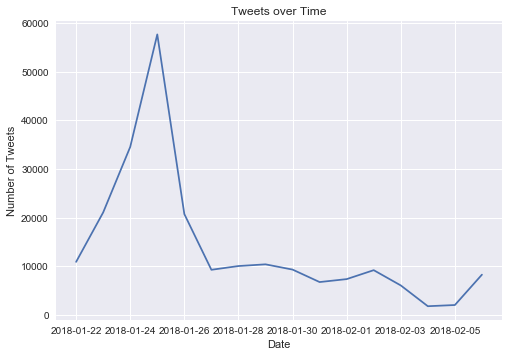

In [15]:
df.groupby(df['tweet_date'].dt.date).size().plot()
plt.title('Tweets over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

#### Process text for analysis

In [16]:
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
words = (df['text']
           .str.lower()
           .replace([r'\|', RE_stopwords, r"(&amp)|,|;|\"|\.|\?|’|!|'|:|-|\\|/|https"], [' ', ' ', ' '], regex=True)
           .str.cat(sep=' ')
           .split()
)

#### Most frequent words

In [17]:
rslt = pd.DataFrame(Counter(words).most_common(50),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt = rslt.iloc[5:] 
#top terms removed from graph because they are the search terms for the data collection

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


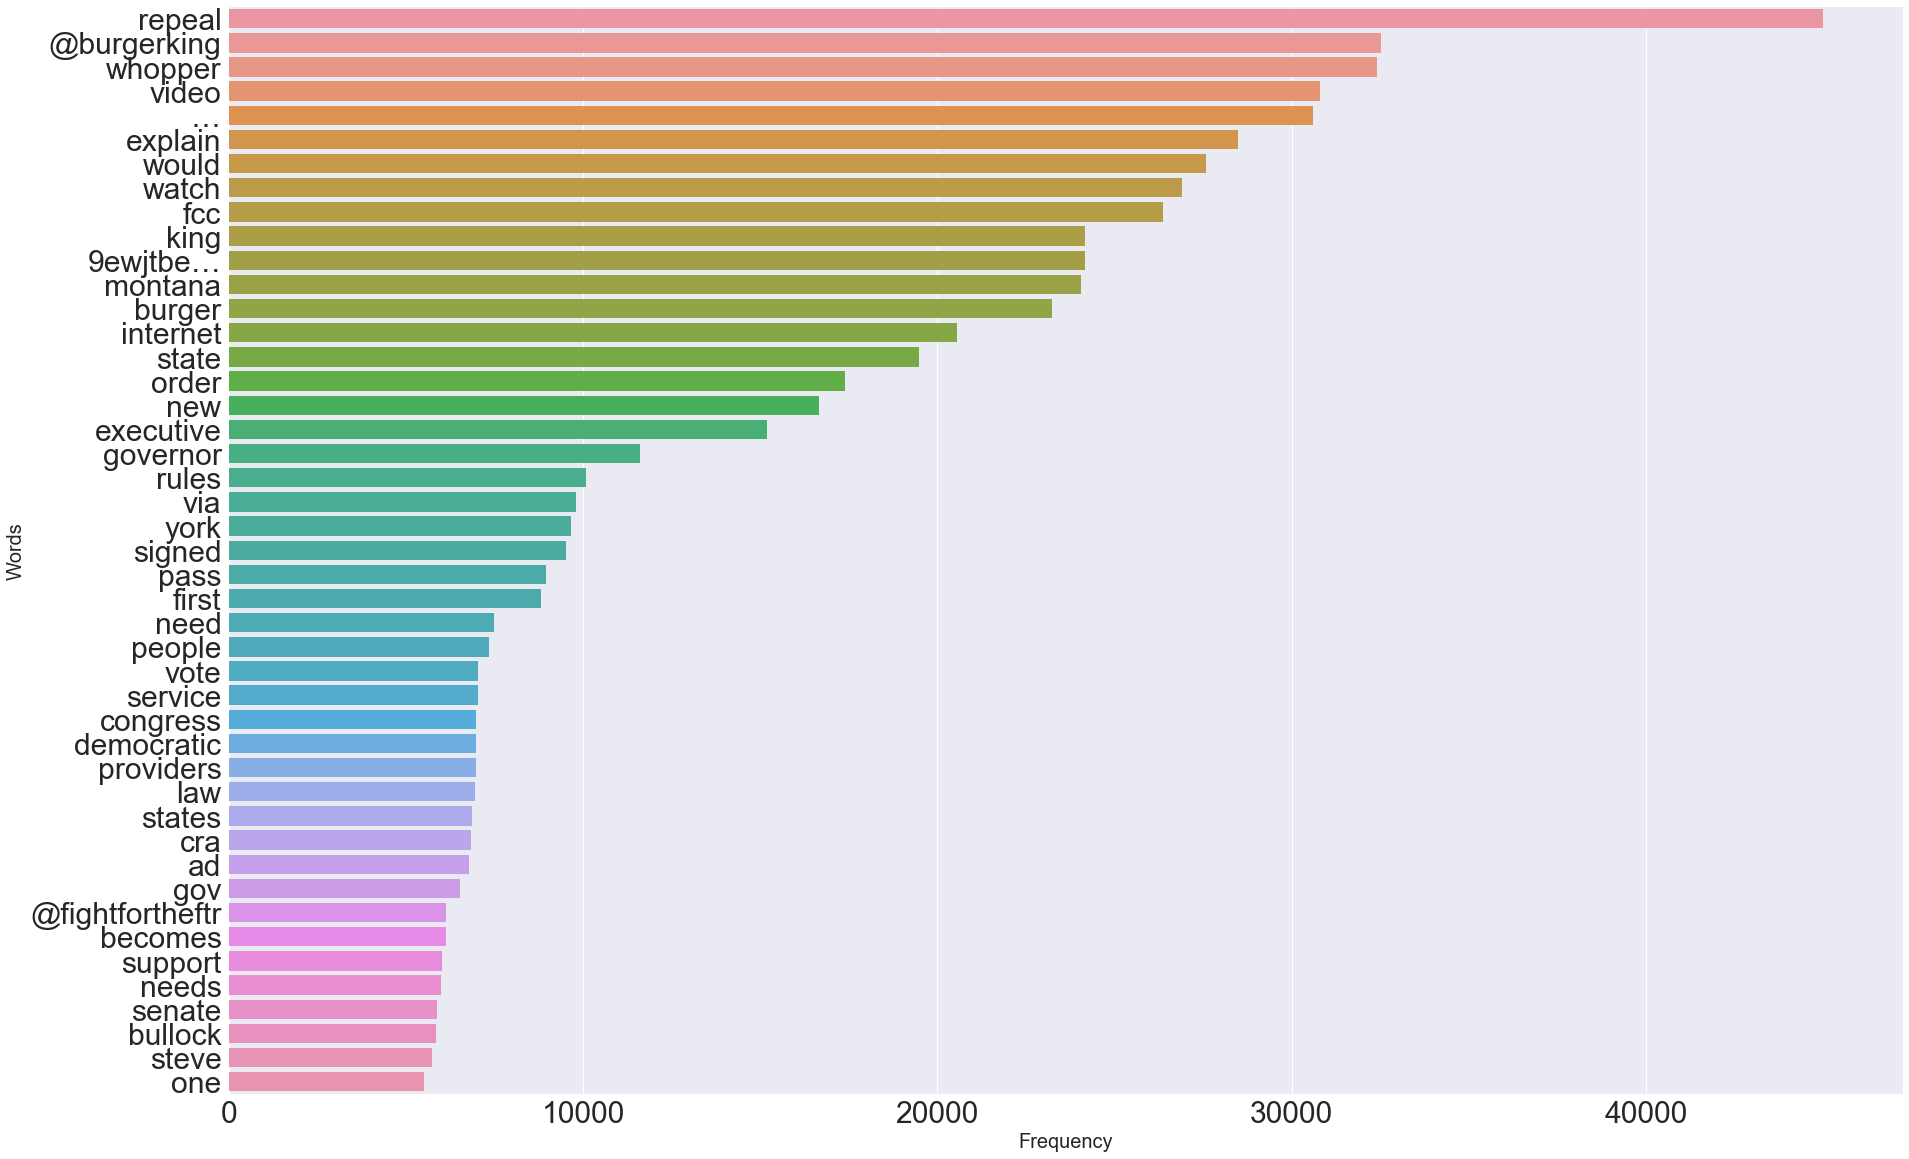

In [18]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [30.0, 20.0]
ax = sns.barplot(y=rslt.index, x='Frequency', data=rslt)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Words",fontsize=20)
ax.tick_params(labelsize=30)

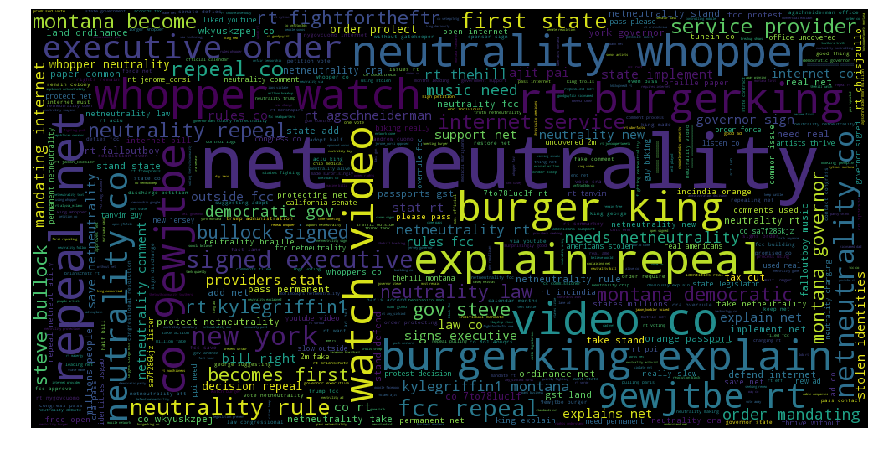

In [21]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500, max_words = 500).generate(' '.join(words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Word Co-Occurrences

In [22]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words, 2)
finder.apply_freq_filter(5)
for bigram in finder.nbest(bigram_measures.likelihood_ratio, 20):
    print(bigram)

('net', 'neutrality')
('burger', 'king')
('would', 'explain')
('watch', 'video')
('whopper', 'watch')
('@burgerking', 'would')
('explain', 'repeal')
('executive', 'order')
('co', '9ewjtbe…')
('repeal', 'net')
('video', 'co')
('neutrality', 'whopper')
('rt', '@burgerking')
('new', 'york')
('signed', 'executive')
('steve', 'bullock')
('service', 'providers')
('9ewjtbe…', 'rt')
('first', 'state')
('becomes', 'first')


#### Most Frequent Links

In [23]:
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

In [24]:
df['link'] = df['text'].apply(lambda tweet: extract_link(tweet))
tweets_with_link = df[df['link'] != '']

In [25]:
rslt3 = pd.DataFrame(Counter(tweets_with_link['link']).most_common(10),
                    columns=['Link', 'Frequency']).set_index('Link')

rslt3 = rslt3.iloc[1:]

In [26]:
print(rslt3)

                         Frequency
Link                              
https://t.co/wkyUSkzpeJ       2116
https://t.co/sA7f286KJZ       1602
https://t.co/k6CkqtnEB8       1044
https://t.co/…                 873
https://t.co/vmfTTWd3dM        815
https://t.co/vEtEqo1dTG        656
https://t.co/oabVsUk0sc        582
https://t.co/FOwGhk4B7a        552
https://t.co/zTIthImIFV        538


#### Tweets by Location

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


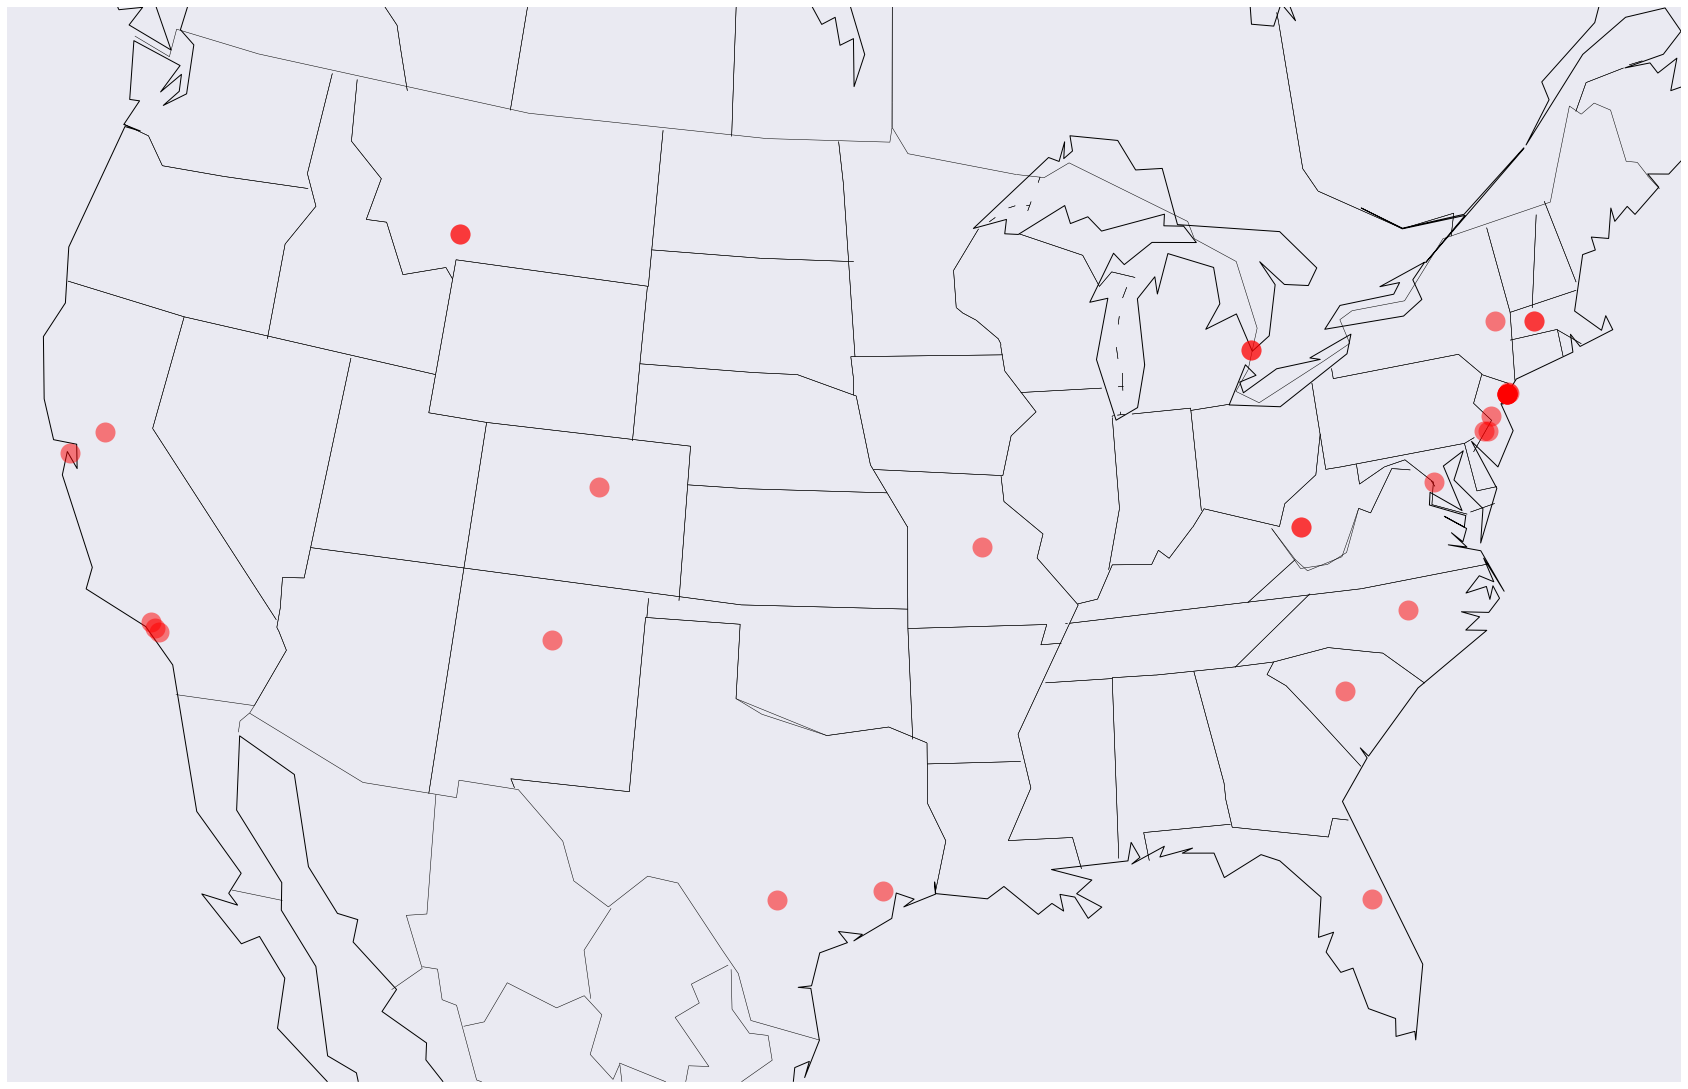

In [27]:
from mpl_toolkits.basemap import Basemap


my_map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='c')
my_map.drawcoastlines()
my_map.drawstates()
my_map.drawcountries()
# add coordinates as red dots
longs = list(df.loc[(df.long != 'NaN')].long)
latts = list(df.loc[df.latt != 'NaN'].latt)
x, y = my_map(longs, latts)
my_map.plot(x, y, 'ro', markersize=20, alpha=0.5)
 
plt.show()

#### Top Users

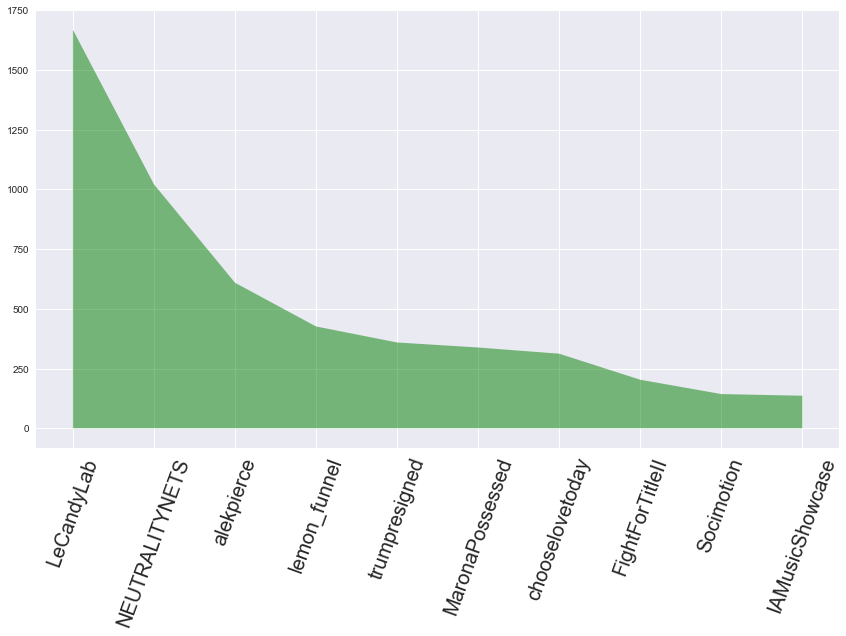

In [33]:
from pandas import value_counts
user_counts = df.screen_name.value_counts()[:10]
fig, ax = plt.subplots(1, figsize=(12, 9))
x = np.arange(len(user_counts.index))
ax.stackplot(x, user_counts.values, colors='g', alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(user_counts.index, fontsize=20, rotation=70)
ax.grid(color='w', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

## FCC Public Comments Data

#### Import Data

In [34]:
fcc = pd.read_csv('~/Desktop/proc_17_108_unique_comments_text_dupe_count.csv', index_col='docid')

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Data Wrangling

In [35]:
fcc.head()

,text_data,dupe_count
docid,,
2,I work as an engineering manager at a small vi...,1.0
3,"Dear FCC,\r\n\r\nclowns. traitors. pawns pre...",1.0
5,I am AGAINST the push to remove net neutrality...,1.0
6,"Guys, I seriously don't understand your reason...",1.0
8,I do not support this proposal. Having a neut...,1.0


In [36]:
fcc.shape

(2955186, 2)

In [37]:
fcc.text_data.nunique()

2955181

In [38]:
# Remove duplicate comments
fcc = fcc.drop_duplicates(["text_data"])
fcc.shape

(2955182, 2)

In [39]:
fcc.dtypes

text_data      object
dupe_count    float64
dtype: object

#### Exploratory Data Analysis

In [41]:
fccwords = (fcc['text_data']
           .str.lower()
           .replace([r'\|', RE_stopwords, r"(&amp)|,|;|\"|\.|\?|’|!|'|:|-|\\|/|https"], [' ', ' ', ' '], regex=True)
           .str.cat(sep=' ')
           .split()
)

In [42]:
rslt4 = pd.DataFrame(Counter(fccwords).most_common(50),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt4 = rslt4.iloc[1:]

#### Most frequent words

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


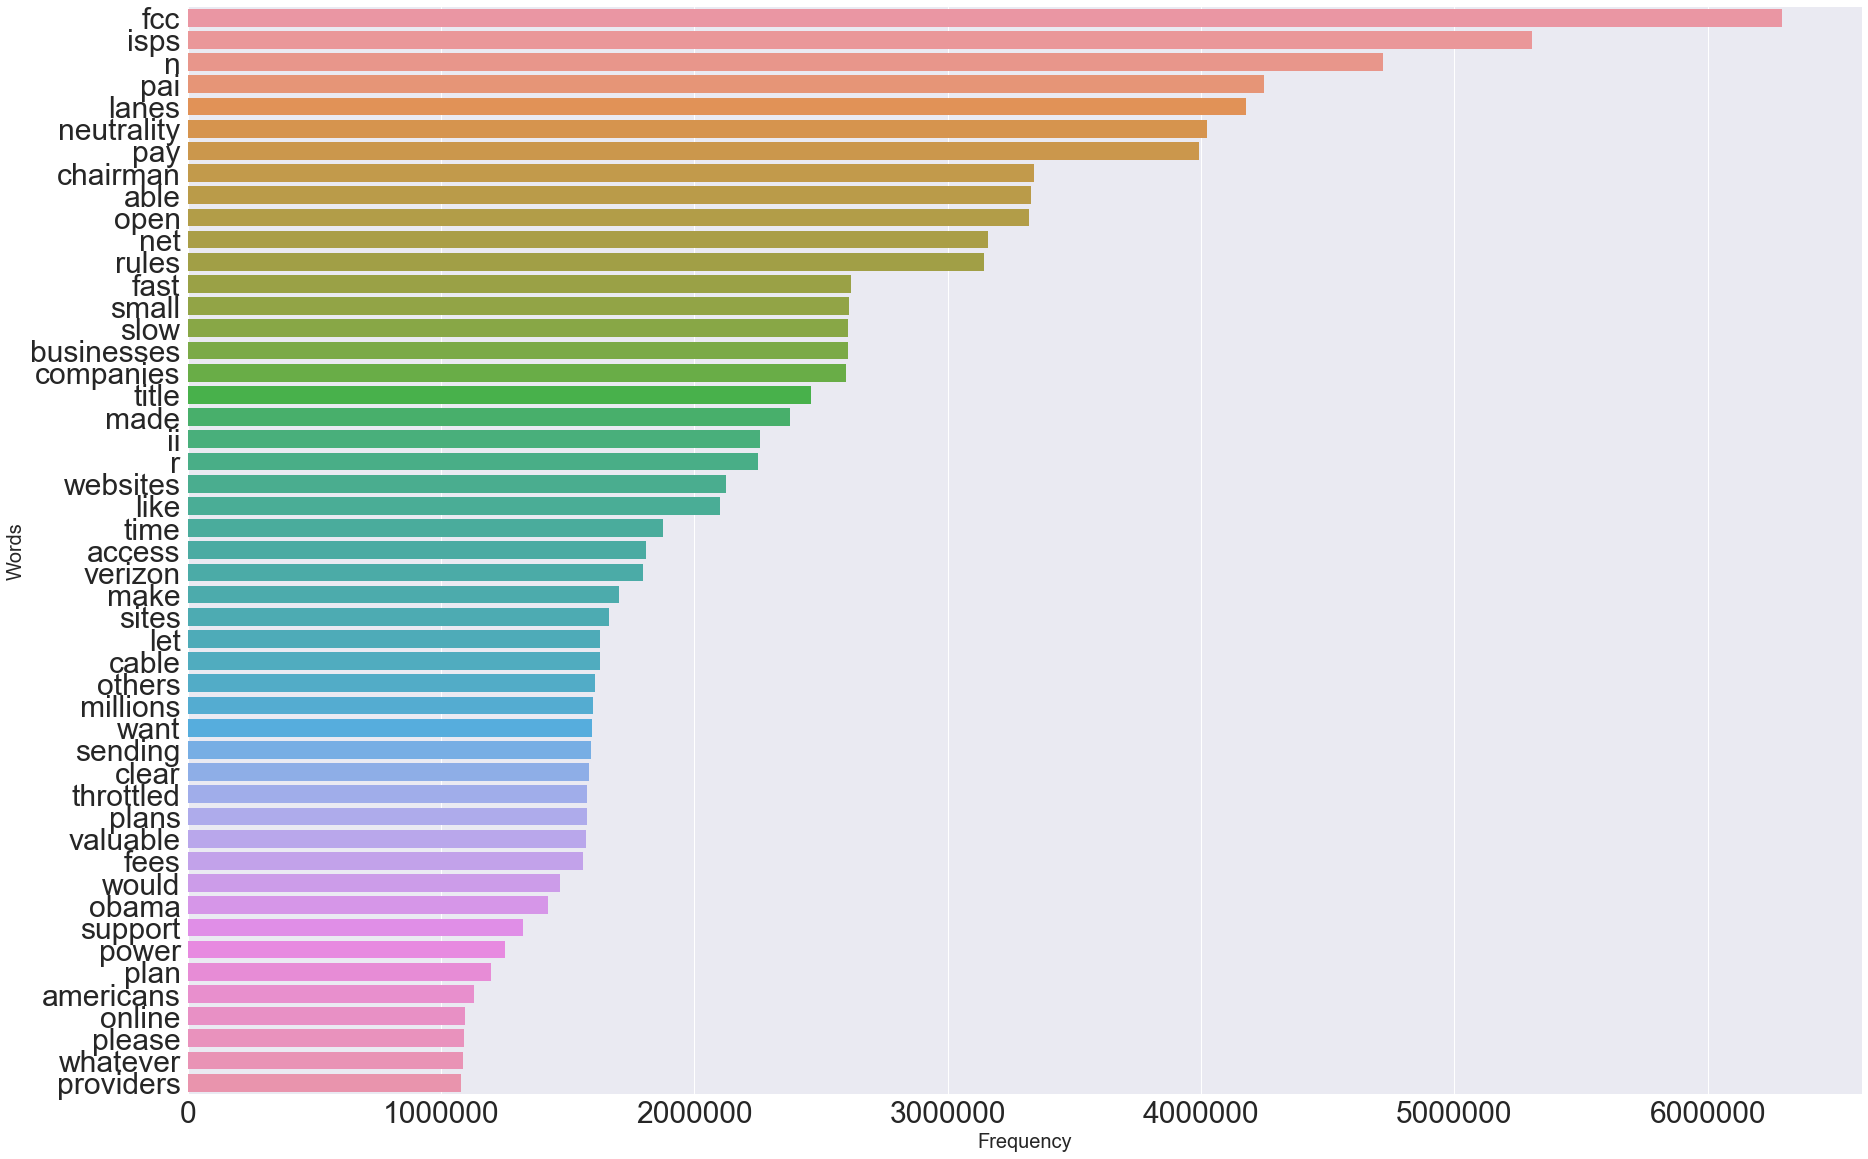

In [43]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [30.0, 20.0]
ax = sns.barplot(y=rslt4.index, x='Frequency', data=rslt4)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Words",fontsize=20)
ax.tick_params(labelsize=30)

In [44]:
wordcloud2 = WordCloud(width = 1000, height = 500, max_words=100).generate(' '.join(fccwords))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

KeyboardInterrupt: 

In [ ]:
finder2 = BigramCollocationFinder.from_words(fccwords, 2)
finder2.apply_freq_filter(5)
for bigram in finder2.nbest(bigram_measures.likelihood_ratio, 20):
    print(bigram)